In [69]:
!pip install pandas_ta
!pip install neat-python
!pip install numba


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 10.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 10.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
"""
from google.colab import drive
drive.mount('/content/drive')
"""

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [70]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import threading
from numba import jit
import neat
import os
import os.path

In [7]:
def get_relative_change(df, column_name):
    relative_changes = []
    for i in range(len(df)):
        if i == 0:
            relative_changes.append(0)  # First element has no previous value
        else:
            relative_change = (df.iloc[i] - df.iloc[i-1]) / df.iloc[i-1]
            relative_changes.append(relative_change)
    return pd.DataFrame({column_name: relative_changes})

In [9]:
df = pd.read_csv('/tmp/eurusd_hour.csv')
close = df['AC']
open = df['AO']
high = df['AH']
low = df['AL']


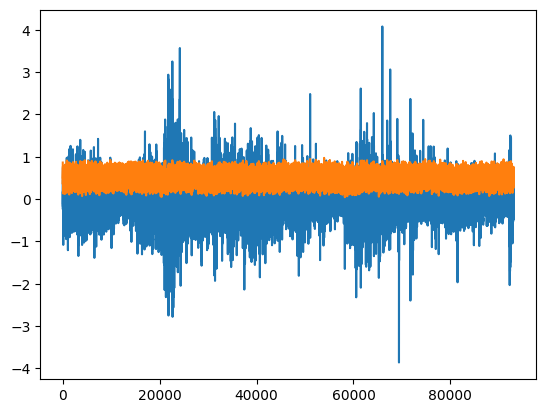

In [10]:
close_np = close.to_numpy()


# Calculate the rolling velocity
RSI = ta.rsi(close,10,scalar=1)
ROC = ta.roc(close,8)
CHANGE = get_relative_change(close,"Change")

INDICATORS = pd.concat([ROC,RSI,CHANGE],axis=1)

INDICATORS = INDICATORS.dropna(axis=0)
INDICATORS = INDICATORS.reset_index()
INDICATORS.pop('index')

change = INDICATORS.pop('Change')
INDICATORS = INDICATORS.to_numpy()
change = change.to_numpy()
change_dev = change.std()
change = change/change_dev


plt.plot(INDICATORS)

In [139]:
def run_env_loop(net):
    trade_info = np.array([0, 0,0])
    profit = 0
    returns = np.array([])
    for count in range(10000, 10400):
        state = np.concatenate((INDICATORS[count], trade_info))
        action = net.activate(state)
        cash_out = 0
        buy = 1 if action[0] > .6 else 0
        sell = 1 if action[0] < .3 else 0

        if buy == 1:
            trade_direction = 1
        if sell == 1:
            trade_direction = -1
        else:
            trade_direction = 0

            
            
        if trade_direction == trade_info[0]:          
            profit += change[count] * trade_direction
            trade_info[0] = trade_direction
            trade_info[1] += 0.5
            trade_info[2] = profit            
        else:
            trade_info[0] = trade_direction
            trade_info[1] = 0
            trade_info[2] = 0
            cash_out = profit
            profit = change[count] * trade_direction
            
        if cash_out != 0:
            returns = np.append(returns,cash_out)


    return np.mean(returns) if len(returns)>1 else 0



def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        genome.fitness = run_env_loop(net)

In [140]:
"""
!git clone https://github.com/CodeReclaimers/neat-python
"""

'\n!git clone https://github.com/CodeReclaimers/neat-python\n'

In [141]:
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     '/tmp/config-feedforward')
p = neat.Population(config)
p.add_reporter(neat.StdOutReporter(False))

In [ ]:
winner = p.run(eval_genomes, 30000)


 ****** Running generation 88 ****** 

Population's average fitness: 1.88805 stdev: 2.63622
Best fitness: 8.85554 - size: (5, 7) - species 4 - id 72054
Average adjusted fitness: 0.381
Mean genetic distance 2.354, standard deviation 0.928
Population of 1001 members in 7 species
Total extinctions: 0
Generation time: 3.424 sec (3.401 average)

 ****** Running generation 89 ****** 

Population's average fitness: 1.99404 stdev: 2.63272
Best fitness: 8.85554 - size: (5, 7) - species 4 - id 72054
Average adjusted fitness: 0.491
Mean genetic distance 2.374, standard deviation 0.870
Population of 1000 members in 7 species
Total extinctions: 0
Generation time: 3.665 sec (3.442 average)

 ****** Running generation 90 ****** 

Population's average fitness: 2.03927 stdev: 2.62448
Best fitness: 8.85554 - size: (5, 7) - species 4 - id 72054
Average adjusted fitness: 0.397
Mean genetic distance 2.385, standard deviation 0.878
Population of 1001 members in 7 species
Total extinctions: 0
Generation tim